# Introduction to Neural Networks with PyTorch

This notebook introduces key concepts in neural networks using PyTorch. We cover:

1. **Perceptron:** A simple linear classifier. We show a basic example and discuss the linear limitations by trying to solve the XOR problem.
2. **Single Neuron:** How a single neuron with a nonlinear activation (e.g., Sigmoid) differs from a perceptron and why the activation is critical.
3. **MNIST Classification:** Building a feedforward neural network to classify handwritten digits. We detail the feedforward and backpropagation processes, use a specific loss function, and compute accuracy, precision, and recall.
4. **Nonlinear Regression & Regularization:** We use a polynomial function as our data generating process and build a regressor. Regularization techniques (L1, L2, dropout, and early stopping) are introduced, and we plot training/validation losses to illustrate overfitting.

Mathematical formulations (in brief):

- **Perceptron:**  
  $$ y = f\left(\sum_{i=1}^{n} w_i x_i + b\right) $$  
  where $ f $ is usually a step function.

- **Neuron with Activation:**  
  $$ y = \sigma\left(\sum_{i=1}^{n} w_i x_i + b\right) $$  
  where $ \sigma $ is a nonlinear activation function (e.g., sigmoid, ReLU).

- **Cross-Entropy Loss (for classification):**  
  $$ \mathcal{L}_{CE} = -\sum_{c} y_c \log(\hat{y}_c) $$


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

# For MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 1. Perceptron and Its Limitations

A perceptron is a linear classifier that computes:

$$ y = f\left(\mathbf{w}^\top \mathbf{x} + b\right) $$

where the activation function $ f $ is typically a step function. However, this linear model cannot solve non-linearly separable problems like XOR.

### Example: The XOR Problem

The XOR dataset:

- Inputs:  
  $$ X = \begin{bmatrix} 0 & 0 \\ 0 & 1 \\ 1 & 0 \\ 1 & 1 \end{bmatrix} $$

- Targets (XOR):  
  $$ y = \begin{bmatrix} 0 \\ 1 \\ 1 \\ 0 \end{bmatrix} $$

Let's try to train a single-layer perceptron on this dataset.


In [ ]:
# XOR dataset
X = torch.tensor([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]], dtype=torch.float32)
y = torch.tensor([[0],
                  [1],
                  [1],
                  [0]], dtype=torch.float32)

# Define a simple perceptron (linear layer only)
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(2, 1)  # 2 input features, 1 output

    def forward(self, x):
        # Notice: no non-linear activation; this is a linear model!
        out = self.linear(x)
        return out

# Initialize the model, loss function and optimizer.
model = Perceptron().to(device)
criterion = nn.MSELoss()  # using MSE loss for simplicity
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
epochs = 1000
X_device = X.to(device)
y_device = y.to(device)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_device)
    loss = criterion(outputs, y_device)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
with torch.no_grad():
    preds = model(X_device)
    preds_class = (preds > 0.5).float()
    print("\nInput\tPredicted\tTarget")
    for inp, pred, target in zip(X, preds_class, y):
        print(inp.numpy(), "\t", pred.item(), "\t\t", target.item())


Epoch 200/1000, Loss: 0.2500
Epoch 400/1000, Loss: 0.2500
Epoch 600/1000, Loss: 0.2500
Epoch 800/1000, Loss: 0.2500
Epoch 1000/1000, Loss: 0.2500

Input	Predicted	Target
[0. 0.] 	 1.0 		 0.0
[0. 1.] 	 1.0 		 1.0
[1. 0.] 	 1.0 		 1.0
[1. 1.] 	 0.0 		 0.0


**Observation:**  
The perceptron (a linear model) cannot correctly learn the XOR function due to its inherent linear limitations.

---

## 2. Single Neuron with Activation Function

Adding a nonlinear activation function allows a neuron to model nonlinearities. For a single neuron:

$$ y = \sigma\left(\mathbf{w}^\top \mathbf{x} + b\right) $$

where $ \sigma $ is a nonlinear function (e.g., Sigmoid). This is equivalent to logistic regression.

### Example: Single Neuron with Sigmoid Activation

Let's build a model that uses a sigmoid activation to perform a binary classification on a simple dataset.


In [ ]:
# Define a single neuron model with a sigmoid activation function.
class SingleNeuron(nn.Module):
    def __init__(self):
        super(SingleNeuron, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)  # This time we are using a non-linear activation
        return out

# Initialize model, loss function, optimizer
model_neuron = SingleNeuron().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = optim.SGD(model_neuron.parameters(), lr=0.1)

# Training loop on the same XOR dataset (for illustration)
for epoch in range(2000):
    optimizer.zero_grad()
    outputs = model_neuron(X_device)
    loss = criterion(outputs, y_device)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 400 == 0:
        print(f"Epoch {epoch+1}/2000, Loss: {loss.item():.4f}")

# Evaluate
with torch.no_grad():
    preds = model_neuron(X_device)
    preds_class = (preds > 0.5).float()
    print("\nInput\tPredicted\tTarget")
    for inp, pred, target in zip(X, preds_class, y):
        print(inp.numpy(), "\t", pred.item(), "\t\t", target.item())

Epoch 400/2000, Loss: 0.6933
Epoch 800/2000, Loss: 0.6931
Epoch 1200/2000, Loss: 0.6931
Epoch 1600/2000, Loss: 0.6931
Epoch 2000/2000, Loss: 0.6931

Input	Predicted	Target
[0. 0.] 	 1.0 		 0.0
[0. 1.] 	 1.0 		 1.0
[1. 0.] 	 0.0 		 1.0
[1. 1.] 	 0.0 		 0.0


**Observation:**  
With the sigmoid activation, the neuron now outputs probabilities between 0 and 1. However, note that a **single neuron** is still a linear classifier and cannot solve the XOR problem. To model non-linear functions like XOR, we need a network with at least one hidden layer.

**Try to develop on your own a more performant model!**

---

## 3. MNIST Classification Using a Neural Network

In this section, we build a feedforward neural network to classify MNIST digits.

**Key points:**

- **Feedforward:** Input data passes through multiple layers.
- **Backpropagation:** The error is propagated back through the network to update weights.
- **Loss Function:** We use Cross-Entropy Loss defined as:

  $$ \mathcal{L}_{CE} = -\sum_{c} y_c \log(\hat{y}_c) $$

- We also compute evaluation metrics: accuracy, precision, and recall.



In [ ]:
# Define a simple feedforward network for MNIST classification.
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # outputs are logits
        return x

# Data transforms and dataset loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss and optimizer.
model_mnist = MNISTNet().to(device)
criterion = nn.CrossEntropyLoss()  # Combines LogSoftmax and NLLLoss
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model_mnist.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_mnist(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation: compute accuracy, precision, and recall.
model_mnist.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_mnist(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
accuracy = (all_preds == all_labels).float().mean().item()
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# Compute precision and recall per class (macro-average)
num_classes = 10
precision = []
recall = []
for c in range(num_classes):
    tp = ((all_preds == c) & (all_labels == c)).sum().item()
    fp = ((all_preds == c) & (all_labels != c)).sum().item()
    fn = ((all_preds != c) & (all_labels == c)).sum().item()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision.append(prec)
    recall.append(rec)

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
print(f"Macro Precision: {macro_precision*100:.2f}%")
print(f"Macro Recall: {macro_recall*100:.2f}%")


Epoch 1/5, Loss: 0.3439
Epoch 2/5, Loss: 0.1453
Epoch 3/5, Loss: 0.0975
Epoch 4/5, Loss: 0.0740
Epoch 5/5, Loss: 0.0573

Test Accuracy: 97.56%
Macro Precision: 97.57%
Macro Recall: 97.54%


## 4. Nonlinear Function Regression and Regularization

In many real‐world tasks, overfitting can cause a model to perform well on training data but generalize poorly, leading to bad results on the testing data. Regularization techniques are used to reduce overfitting by adding constraints to the model.

### Regularization Strategies

1. **L1 Regularization:**  
   Adds the sum of absolute values of the weights to the loss:
   $$ \mathcal{L}_{total} = \mathcal{L}_{MSE} + \lambda_1 \sum_i |w_i| $$

   *Note: This type of regularization promotes sparse weights.*

2. **L2 Regularization (Weight Decay):**  
   Adds the sum of squared weights:
   $$ \mathcal{L}_{total} = \mathcal{L}_{MSE} + \lambda_2 \sum_i w_i^2 $$
  
   *Note: This regularization promotes small weights. In PyTorch, L2 regularization is typically implemented using the `weight_decay` parameter in the optimizer.*

3. **Dropout:**  
   During training, dropout randomly sets a fraction of activations to zero to prevent neurons from co-adapting too much. Mathematically, for a dropout probability \( p \), the output of a layer becomes:
   $$ \tilde{x}_i = x_i \cdot z_i \quad \text{with} \quad z_i \sim \mathrm{Bernoulli}(1-p) $$

4. **Early Stopping:**  
   Monitors the validation loss and stops training if the loss does not improve for a number of epochs, preventing the model from overfitting.

In the following example we model a quadratic function:

$$ y = 2x^2 + 3x + 1 + \epsilon $$

where $ \epsilon $ is Gaussian noise. We will compare a model trained **without** regularization to one trained **with** regularization.


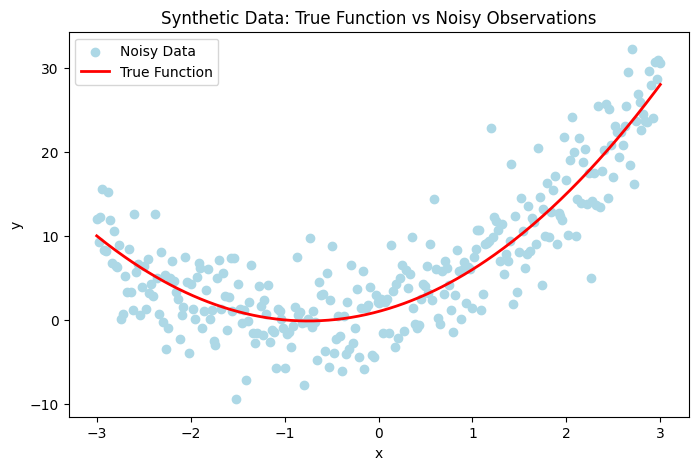

In [ ]:
# Generate synthetic data for a quadratic function with noise.
np.random.seed(42)
torch.manual_seed(42)

# Generate 300 points in the range [-3, 3]
x = np.linspace(-3, 3, 300)
y_true = 2 * x**2 + 3 * x + 1
noise = np.random.normal(0, 4, size=x.shape)
y_noisy = y_true + noise

# Plot the underlying function and the noisy data
plt.figure(figsize=(8, 5))
plt.scatter(x, y_noisy, color='lightblue', label='Noisy Data')
plt.plot(x, y_true, color='red', linewidth=2, label='True Function')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic Data: True Function vs Noisy Observations")
plt.legend()
plt.show()

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_noisy, dtype=torch.float32).unsqueeze(1)

# Split into training and validation sets
train_size = int(0.8 * len(x_tensor))
val_size = len(x_tensor) - train_size
train_x, val_x = torch.split(x_tensor, [train_size, val_size])
train_y, val_y = torch.split(y_tensor, [train_size, val_size])


### Model Architectures

We define two network architectures with the same base structure:

- **RegressionNetNoReg:** A model with no regularization.
- **RegressionNetReg:** A model with dropout built in.

For the regularized model, we will additionally use L1 regularization (manually added in the loss), L2 regularization (via weight decay in the optimizer), and early stopping.


In [ ]:
# Model without regularization
class RegressionNetNoReg(nn.Module):
    def __init__(self):
        super(RegressionNetNoReg, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model with dropout regularization
class RegressionNetReg(nn.Module):
    def __init__(self):
        super(RegressionNetReg, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.dropout = nn.Dropout(0.2)  # 20% dropout
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training Setup

We split the data into training and validation sets.

In [ ]:
# Convert data to PyTorch tensors and split into training and validation sets
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_noisy, dtype=torch.float32).unsqueeze(1)

train_size = int(0.8 * len(x_tensor))
val_size = len(x_tensor) - train_size
train_x, val_x = torch.split(x_tensor, [train_size, val_size])
train_y, val_y = torch.split(y_tensor, [train_size, val_size])

### Training the Models

We now train two models:

1. **Without Regularization:**  
    - No dropout, no weight decay, and no L1 penalty.
    - Trained for a fixed 500 epochs.

2. **With Regularization:**  
    - Uses dropout (in the model), L2 regularization via `weight_decay`, L1 regularization (manually added), and early stopping.

We record training and validation losses for both cases.

In [ ]:
def train_model(model, optimizer, criterion, train_x, train_y, val_x, val_y, num_epochs=500,
                use_l1=False, l1_lambda=0.0, early_stopping=False, patience=20):
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        preds_train = model(train_x.to(device))
        loss_train = criterion(preds_train, train_y.to(device))

        # Add L1 regularization if specified
        if use_l1:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss_train = loss_train + l1_lambda * l1_norm

        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train.item())

        # Validation
        model.eval()
        with torch.no_grad():
            preds_val = model(val_x.to(device))
            loss_val = criterion(preds_val, val_y.to(device))
        val_losses.append(loss_val.item())

        # Early stopping check
        if early_stopping:
            if loss_val.item() < best_val_loss:
                best_val_loss = loss_val.item()
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1:3d}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

    if early_stopping and best_model_state is not None:
        model.load_state_dict(best_model_state)
    return train_losses, val_losses

# Train model without regularization
model_no_reg = RegressionNetNoReg().to(device)
optimizer_no_reg = optim.Adam(model_no_reg.parameters(), lr=0.01)  # no weight decay here
criterion_reg = nn.MSELoss()

print("Training model WITHOUT regularization:")
losses_no_reg_train, losses_no_reg_val = train_model(model_no_reg, optimizer_no_reg, criterion_reg,
                                                     train_x, train_y, val_x, val_y,
                                                     num_epochs=500, use_l1=False, early_stopping=False)

# Train model with regularization (using dropout, L2 weight decay, L1 penalty, and early stopping)
model_reg = RegressionNetReg().to(device)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.01, weight_decay=1e-4)  # L2 regularization via weight decay
l1_lambda = 1e-5
print("\nTraining model WITH regularization:")
losses_reg_train, losses_reg_val = train_model(model_reg, optimizer_reg, criterion_reg,
                                               train_x, train_y, val_x, val_y,
                                               num_epochs=500, use_l1=True, l1_lambda=l1_lambda,
                                               early_stopping=True, patience=20)


Training model WITHOUT regularization:
Epoch  50, Train Loss: 15.4662, Val Loss: 26.7326
Epoch 100, Train Loss: 14.9769, Val Loss: 27.9140
Epoch 150, Train Loss: 14.9616, Val Loss: 28.4526
Epoch 200, Train Loss: 14.9507, Val Loss: 28.3596
Epoch 250, Train Loss: 14.9304, Val Loss: 28.1661
Epoch 300, Train Loss: 14.8969, Val Loss: 28.0752
Epoch 350, Train Loss: 14.8627, Val Loss: 27.8355
Epoch 400, Train Loss: 14.8498, Val Loss: 26.0295
Epoch 450, Train Loss: 14.7893, Val Loss: 26.1721
Epoch 500, Train Loss: 14.7023, Val Loss: 25.6605

Training model WITH regularization:
Early stopping at epoch 44


### Comparison of Loss Evolutions

The following plots show the training and validation losses for both models.


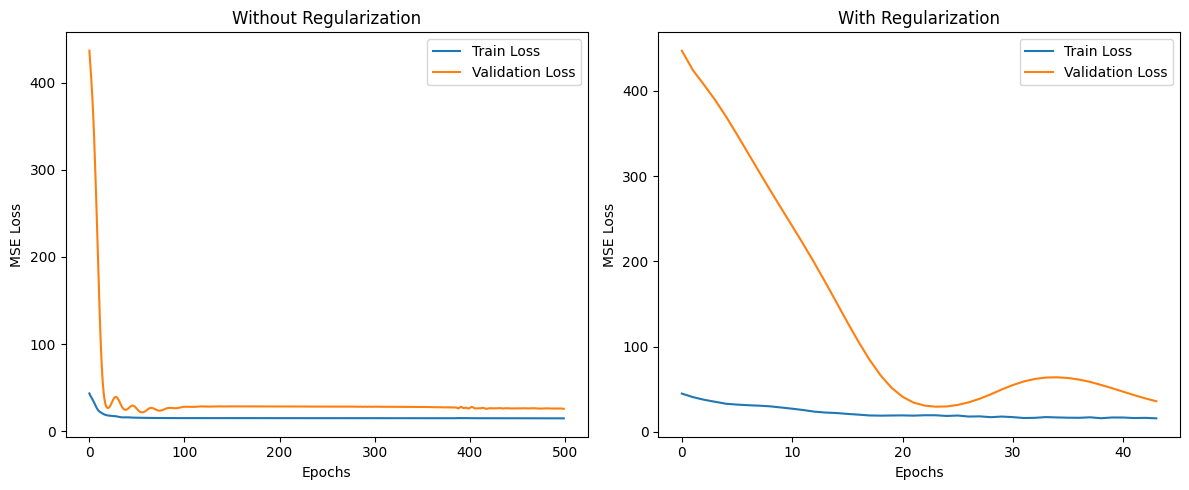

In [ ]:
plt.figure(figsize=(12, 5))

# Plot losses for model without regularization
plt.subplot(1, 2, 1)
plt.plot(losses_no_reg_train, label="Train Loss")
plt.plot(losses_no_reg_val, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Without Regularization")
plt.legend()

# Plot losses for model with regularization
plt.subplot(1, 2, 2)
plt.plot(losses_reg_train, label="Train Loss")
plt.plot(losses_reg_val, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("With Regularization")
plt.legend()

plt.tight_layout()
plt.show()


### Model Predictions Comparison

We now generate predictions from both models on a dense grid and compare them with the true function.


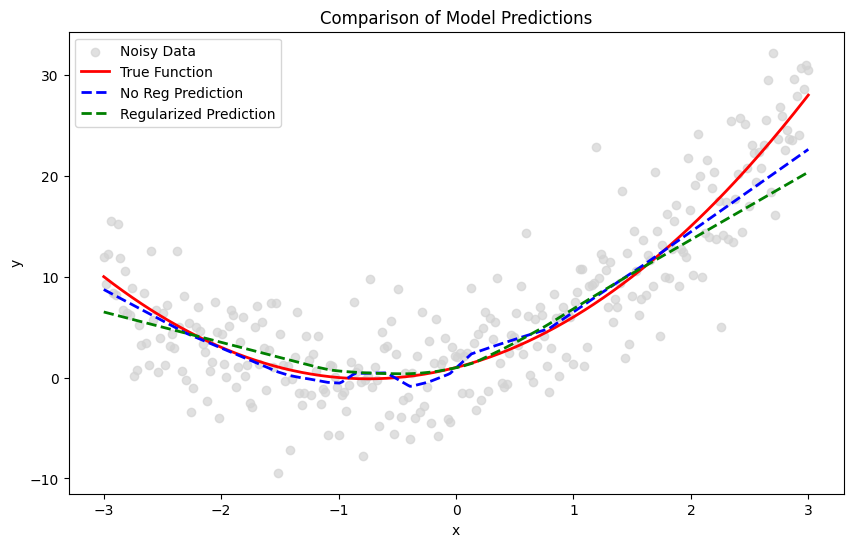

In [ ]:
# Create a dense grid for predictions
x_dense = np.linspace(-3, 3, 300)
x_dense_tensor = torch.tensor(x_dense, dtype=torch.float32).unsqueeze(1).to(device)

model_no_reg.eval()
model_reg.eval()
with torch.no_grad():
    preds_no_reg = model_no_reg(x_dense_tensor).cpu().numpy().flatten()
    preds_reg = model_reg(x_dense_tensor).cpu().numpy().flatten()

plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, color='lightgray', label='Noisy Data', alpha=0.7)
plt.plot(x_dense, y_true, color='red', linewidth=2, label='True Function')
plt.plot(x_dense, preds_no_reg, color='blue', linestyle='--', linewidth=2, label='No Reg Prediction')
plt.plot(x_dense, preds_reg, color='green', linestyle='--', linewidth=2, label='Regularized Prediction')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of Model Predictions")
plt.legend()
plt.show()

**Summary:**

- **Perceptron:** A linear model that cannot solve nonlinear problems like XOR.
- **Single Neuron with Activation:** By adding a nonlinear activation (e.g., sigmoid), we can obtain probabilistic outputs; however, a single neuron remains a linear classifier.
- **MNIST Classification:** A multi-layer network trained via feedforward and backpropagation using cross-entropy loss achieves good performance on digit classification, with computed accuracy, precision, and recall.
- **Nonlinear Regression & Regularization:** Modeling a polynomial function highlights overfitting issues. Regularization techniques (L1, L2, dropout, early stopping) help control overfitting, as seen in the loss evolution plot.

This notebook provides a practical introduction to neural network concepts using PyTorch.